In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from collections import Counter 
import re
from scipy import stats
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold

## Remove Outliers, Missing Data, and Irrelevent Features

In [2]:
df2 = pd.read_json("./data/train.json")
# df2.head(1)
# df2.info()
test_json = pd.read_json("./data/test.json")
test_json.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street


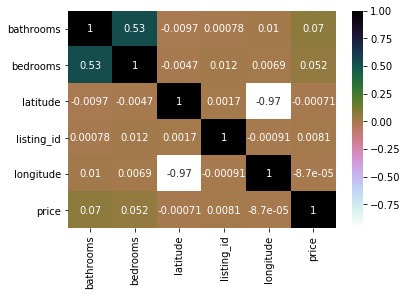

In [3]:
#plt.figure(figsize=(7,4))
sns.heatmap(df2.corr(), annot=True, cmap='cubehelix_r')
#plt.show()
# bathrooms and bedrooms are correlated - 0.53
# longitude and latitude are uncorrelated
# bathrooms and price are correlated - 0.07
# bedrooms and price are correlated - 0.052

In [4]:
# Remove Outliers and Drop Empty Fields
newdf2 = df2[(df2['description'] != '') & (df2['description'] != '<p><a  website_redacted')]
newdf2 = newdf2[newdf2['display_address'] != '']
newdf2 = newdf2[newdf2['features'].str.len() > 0]
newdf2 = newdf2[(newdf2['interest_level'] == 'low') | (newdf2['interest_level'] == 'medium') | (newdf2['interest_level'] == 'high')]
newdf2 = newdf2[(newdf2['price'] != 10) & (newdf2['price'] != 0)]
newdf2 = newdf2[newdf2['latitude'] != 0]
newdf2 = newdf2[newdf2['longitude'] != 0]
# newdf2 = newdf2[newdf2['photos'].str.len() > 0]
newdf2 = newdf2[newdf2['street_address'].str.len() > 0]

newdf2 = newdf2[(np.abs(stats.zscore(newdf2['bathrooms'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['bedrooms'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['latitude'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['longitude'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['price'])) < 3)]

In [5]:
# indexes = list(newdf2.index.values.tolist())
# values = list(newdf2['price'][indexes])
    
# plt.scatter(indexes, df2['price'][indexes], edgecolor = 'black')
# plt.xlabel('indexes')
# plt.ylabel('Number of Bedrooms')
# plt.show()
# newdf2['price'].describe()

In [6]:
# newdf2['features'].head(5)

In [7]:
# show {index # : {# of features : [list of features]}
# dct = {}
# indexes = list(newdf2.index.values.tolist())
# for index in indexes:
#     values = list(newdf2['features'][index])
#     feature_info = {}
#     feature_count = len(values)
# #     print(values)
#     dct[index] = feature_info
#     feature_info[feature_count] = values
# dct

In [8]:
# Createa new column of the total count of text features for each row
dct = {}
indexes = list(newdf2.index.values.tolist())
text_features_count = []
for index in indexes:
    values = list(newdf2['features'][index])
    text_features_count.append(len(values))
# dct

newdf2['text_features_count'] = text_features_count
# newdf2.head(8)

In [9]:
# label interest_level = row : 2
# label interest_level = medium : 1
# label interest_level = high : 0
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
newdf2["interest_level_code"] = lb_make.fit_transform(newdf2["interest_level"])


# newdf2.head(1)

In [10]:
import time
from datetime import datetime

indexes = list(newdf2.index.values.tolist())
datetime_float = []
for index in indexes:
    datetime_obj = datetime.strptime(newdf2['created'][index], '%Y-%m-%d %H:%M:%S') 
    datetime_sec = time.mktime(datetime_obj.timetuple())
    datetime_float.append(datetime_sec)
#     Convert float to datetime obj
#     datetime_obj_after = datetime.fromtimestamp(datetime_sec) 
#     print(datetime_obj, "=>", datetime_sec, "=>", datetime_obj_after)
#     print(type(datetime_sec)) // float
newdf2['datetime_float'] = datetime_float
#newdf2.head(2)


In [11]:
lrdf = newdf2
lrdf['num_photos'] = lrdf['photos'].apply(len)
lrdf['created'] = pd.to_datetime(lrdf['created'])
lrdf['hour'] = lrdf['created'].dt.hour
#lrdf.dtypes

#lrdf = lrdf.drop(columns=['interest_level', 'building_id', 'created', 'description', 'display_address', 'features', 'latitude', 'listing_id', 'longitude', 'manager_id', 'photos', 'street_address'])
lrdf = lrdf.drop(columns=['interest_level', 'building_id', 'description', 'created', 'display_address', 'features', 'datetime_float', 'listing_id', 'manager_id', 'photos', 'street_address'])

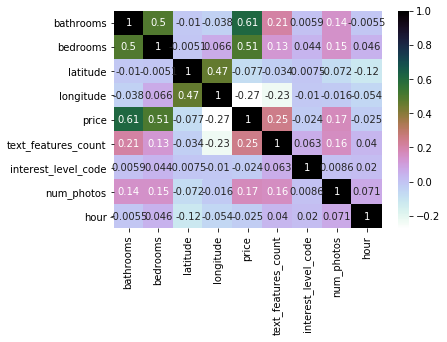

In [12]:
lrdf.head(1)
sns.heatmap(lrdf.corr(), annot=True, cmap='cubehelix_r')


## Logistic Regression Iteration 1

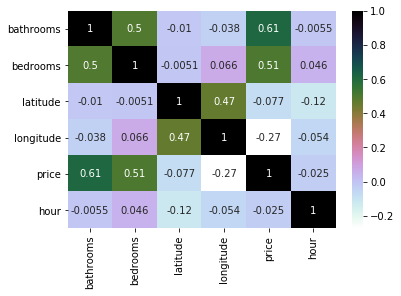

In [15]:
y = lrdf['interest_level_code']
X = lrdf.drop(columns=['interest_level_code'])

#X_alt = X.drop(columns=['text_features_count', 'datetime_float', 'num_photos'])
X_alt = X.drop(columns=['text_features_count', 'num_photos'])

#X_alt['bath_bed'] = X_alt['bathrooms'] + X_alt['bedrooms']

#X_alt = X_alt.drop(columns=['bathrooms', 'bedrooms'])

y.shape, X.shape
X_alt.head(1)
sns.heatmap(X_alt.corr(), annot=True, cmap='cubehelix_r')


In [14]:
# create model
#model = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
#model = linear_model.LogisticRegression(multi_class='multinomial', solver='saga', max_iter=250, penalty='l1', warm_start=True)
model = linear_model.LogisticRegression(multi_class='auto') #multi_class='multinomial', solver='newton-cg' )


#cv = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)

scores = cross_val_score(model, X, np.ravel(y), cv=5)
print("Accuracy: %0.6f (+/- %0.6f)" % (scores.mean(), scores.std() * 2))
#print('coefs:', model.coef_)
#scores
#model.predict_proba(X[2, 6])

# try second model
model2 = linear_model.LogisticRegression(multi_class='multinomial', max_iter=150, solver='saga', penalty='l1') #, class_weight='balanced', warm_start=True)
cv = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores2 = cross_val_score(model2, X_alt, np.ravel(y), cv=cv)
print("Accuracy: %0.6f (+/- %0.6f)" % (scores2.mean(), scores2.std() * 2))


/home/kainoa/.local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.681296 (+/- 0.002812)


/home/kainoa/.local/lib/python2.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy: 0.687917 (+/- 0.012811)


###Generate Predictions to Upload to kaggle